# Importing Libaries

In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FuncFormatter
import itertools
import json
import numpy as np
from pylhe import read_lhe_with_attributes, read_num_events
import itertools
import json
import math
import vector
import mplhep as hep
from scipy.optimize import curve_fit
import os


# Defining Functions

## Importing Data Functions

In [ ]:
def extract_all_particle_data(lhe_file):
    events = read_lhe_with_attributes(lhe_file)
    num_events = read_num_events(lhe_file)

    particle_data = []

    for event_index, event in enumerate(itertools.islice(events, num_events)):
        for particle in event.particles:
            particle_data.append({
                'event': event_index,
                'id': particle.id,
                'px': particle.px,
                'py': particle.py,
                'pz': particle.pz,
                'E': particle.e,
                'status': particle.status,
                'helicity': getattr(particle, 'spin', None)
            })

    return particle_data

def extract_metadata_from_lhe(lhe_file):
    cross_section = None
    com_energy = None
    num_events = None

    with open(lhe_file, 'r') as file:
        for line in file:
            if "Number of Events" in line:
                num_events = int(line.split(":")[1].strip())

            if "Integrated weight (pb)" in line:
                cross_section = float(line.split(":")[1].strip())

            if "<init>" in line:
                init_line = next(file).strip().split()
                beam_energy_1 = float(init_line[2])
                beam_energy_2 = float(init_line[3])
                com_energy = (beam_energy_1 + beam_energy_2) / 1000  # TeV
                break

    return {"cross_section": cross_section, "center_of_mass_energy": com_energy, "number_of_events": num_events}


def filter_by_id(particle_data, particle_id):
    return [particle for particle in particle_data if particle['id'] == particle_id]

def export_data(energy_level, triboson_mass, muon_theta_angles, electron_neutrino_theta_angles, electron_theta_angles):
    data = {
        "Triboson Mass": triboson_mass,
        "Muon Polar Angle": muon_theta_angles,
        "Electron Neutrino Polar Angle": electron_neutrino_theta_angles,
        "Electron Polar Angle": electron_theta_angles,
    }
    
    df = pd.DataFrame(data)
    filename = f"data_{energy_level}.csv"
    df.to_csv(filename, index=False)
    print(f"Data exported to {filename}")


def export_data_PT(energy_level, boson_type, com_four_mom):

    transervse_momentum = np.sqrt(com_four_mom.px**2 + com_four_mom.py**2)
    data = {
        "Transverse momentum": transervse_momentum,
    }
    
    df = pd.DataFrame(data)
    filename = f"Transverse_momentum_data_for_{boson_type}_at_{energy_level}.csv"
    df.to_csv(filename, index=False)
    print(f"Data exported to {filename}")

### Constructing Momentums 

In [3]:
def construct_four_vector(data_set):

    four_vector = vector.array({"E": [data["E"] for data in data_set], 
                                "px": [data["px"] for data in data_set], 
                                "py": [data["py"] for data in data_set], 
                                "pz": [data["pz"] for data in data_set]})
    
    return four_vector

def construct_three_momentum(four_vector):

    three_momentum = vector.array({"px": four_vector.px, 
                                   "py": four_vector.py, 
                                   "pz": four_vector.pz})
    return three_momentum

## Validation Functions

### Invariant Mass Check

In [4]:
def invariant_mass_check(vector_1, vector_2):
    inv_masss_1 = vector_1.E**2 - ( vector_1.px**2 + vector_1.py**2 + vector_1.pz**2 )
    inv_masss_2 = vector_2.E**2 - ( vector_2.px**2 + vector_2.py**2 + vector_2.pz**2 )

    mass_diff = np.isclose(inv_masss_1, inv_masss_2, atol=1e-7)
    
    if np.all(mass_diff):
        return

    else:
        changed_indices = np.where(~mass_diff)[0]
        for idx in changed_indices:
            print(f"Warning: Invariant mass changed at index {idx}! Initial: {vector_1.mass[idx]}, Final: {vector_2.mass[idx]}")
    
    return

### Momentum Conservation Check

In [5]:
def momentum_conservation_check(muon_vector, anti_muon_vector):

    total_px = muon_vector.px + anti_muon_vector.px
    total_py = muon_vector.py + anti_muon_vector.py
    total_pz = muon_vector.pz + anti_muon_vector.pz

    px_check = np.isclose(total_px, 0, atol=1e-5)
    py_check = np.isclose(total_py, 0, atol=1e-5)
    pz_check = np.isclose(total_pz, 0, atol=1e-5)

    # Check for px
    if np.all(px_check):
        return
    else:
        failed_indices = np.where(~px_check)[0]
        for idx in failed_indices:
            print(f"Warning: Total px failed at index {idx}: Value = {total_px[idx]}")

    # Check for py
    if np.all(py_check):
        return
    else:
        failed_indices = np.where(~py_check)[0]
        for idx in failed_indices:
            print(f"Warning: Total py failed at index {idx}: Value = {total_py[idx]}")

    # Check for pz
    if np.all(pz_check):
        return
    else:
        failed_indices = np.where(~pz_check)[0]
        for idx in failed_indices:
            print(f"Warning: Total pz failed at index {idx}: Value = {total_pz[idx]}")

    # Final summary
    overall_passed = np.all(px_check) and np.all(py_check) and np.all(pz_check)
    if overall_passed:
        return
    else:
        print("Momentum conservation check failed.")

    return overall_passed

### Rotation Check

In [6]:
def rotation_check(original_vector, rotated_vector, rotation_axis, tolerance=1e-6):


    # Normalize the rotation axis
    rotation_axis_norm = abs(rotation_axis)
    if rotation_axis_norm < tolerance:
        print("The rotation axis is too small or zero.")
        return False

    rotation_axis_normalized = [
        rotation_axis.px / rotation_axis_norm,
        rotation_axis.py / rotation_axis_norm,
        rotation_axis.pz / rotation_axis_norm
    ]

    # Normalize original and rotated vectors
    original_norm = abs(original_vector)
    rotated_norm = abs(rotated_vector)

    # Check if both vectors are non-zero
    if np.all(original_norm < tolerance) or np.all(rotated_norm < tolerance):
        print("One of the vectors is too small or zero.")
        return False

    # Get the angle between the original and rotated vectors using the dot product
    dot_product = (rotation_axis.px * rotated_vector.px +
                   rotation_axis.py * rotated_vector.py +
                   rotation_axis.pz * rotated_vector.pz)

    angle = np.arccos(dot_product / (rotation_axis_norm * rotated_norm))
    angle_deg = np.degrees(angle)

    # Check the angle to determine if the rotation is correct
    # The expected angle depends on your application; you can set it or calculate it based on the specific rotation
    expected_angle_1 = np.full(angle_deg.shape, 0)  # Same size as angle_deg
    expected_angle_2 = np.full(angle_deg.shape, 180.0)  # Same size as angle_deg
    
    angle_diff_1 = np.isclose(angle_deg, expected_angle_1, atol=tolerance)
    angle_diff_2 = np.isclose(angle_deg, expected_angle_2, atol=tolerance)
    combined_angle_diff = np.logical_or(angle_diff_1, angle_diff_2)


    if np.all(combined_angle_diff):
        return

    else:
        changed_indices = np.where(~combined_angle_diff)[0]
        for idx in changed_indices:
            print(f"Warning: Rotation check failed at Index {idx}."
              f"Calculated angle: {angle_deg[idx]} degrees.")




## Rotation Function

In [7]:
def rotate_vector(affected_vector, rotation_axes, rotation_angles):

    rotated_x = np.array(
        (np.cos(rotation_angles) + (1 - np.cos(rotation_angles)) * rotation_axes.x**2) * affected_vector.x +
        (rotation_axes.x * rotation_axes.y * (1 - np.cos(rotation_angles))) * affected_vector.y +
        rotation_axes.y * np.sin(rotation_angles) * affected_vector.z
    )
    
    rotated_y = np.array(
        rotation_axes.px * rotation_axes.py * (1 - np.cos(rotation_angles)) * affected_vector.px +
        (np.cos(rotation_angles) + (1 - np.cos(rotation_angles)) * rotation_axes.py**2) * affected_vector.py -
        rotation_axes.px * np.sin(rotation_angles) * affected_vector.z
    )
        
    rotated_z = np.array(
        -rotation_axes.py * np.sin(rotation_angles) * affected_vector.px +
        rotation_axes.px * np.sin(rotation_angles) * affected_vector.py +
        np.cos(rotation_angles) * affected_vector.z
    )

    rotated_vector = vector.array({"E": affected_vector.E, "px": rotated_x, "py": rotated_y,"pz": rotated_z}) 

    return rotated_vector



## Boost Function

In [8]:
def boost_vector(affected_vector, reference_vector):
    
    beta = reference_vector.pz / reference_vector.E
    gamma = 1 / np.sqrt(1 - beta**2)

    E_boosted = gamma * (affected_vector.E - beta*affected_vector.pz)
    pz_boosted = gamma * (affected_vector.pz - beta * affected_vector.E )
    px_boosted = affected_vector.px
    py_boosted = affected_vector.py

    boosted_vector = vector.array({"E": E_boosted, "px": px_boosted, "py": py_boosted,"pz": pz_boosted}) 

    return boosted_vector

## Rotate and Boost

In [9]:
def rotate_and_boost(affected_vector, reference_vector, axis):

    # Define Three Vectors
    affected_three_vector = construct_three_momentum(affected_vector)
    reference_three_vector = construct_three_momentum(reference_vector)

    # Finding Rotaton Axes and Angles
    rotation_axes = reference_three_vector.cross(axis).unit()
    cos_theta = reference_three_vector.dot(axis) / abs(reference_three_vector) * abs(axis)
    rotation_angles = np.arccos(cos_theta)

    # Rotate reference vector
    rotated_reference_four_vector = rotate_vector(reference_vector, rotation_axes, rotation_angles)
    rotated_reference_three_vector = vector.array({"px": rotated_reference_four_vector.px, "py": rotated_reference_four_vector.py,"pz": rotated_reference_four_vector.pz}) 
    invariant_mass_check(reference_vector, rotated_reference_four_vector)
    rotation_check(reference_three_vector, rotated_reference_three_vector, axis)

    # Rotate affected vector
    rotated_affected_four_vector = rotate_vector(affected_vector, rotation_axes, rotation_angles)
    rotated_affected_three_vector = vector.array({"px": rotated_affected_four_vector.px, "py": rotated_affected_four_vector.py,"pz": rotated_affected_four_vector.pz}) 
    invariant_mass_check(affected_vector, rotated_affected_four_vector)

    # Boost the affected vector
    rotated_boosted_affected_vector = boost_vector(rotated_affected_four_vector, rotated_reference_four_vector )
    invariant_mass_check(rotated_affected_four_vector, rotated_boosted_affected_vector)

    return rotated_boosted_affected_vector

## Angle Functions

In [10]:
def find_polar_angle(four_vector):
    cos_theta =  four_vector.pz / np.sqrt(four_vector.px**2 + four_vector.py**2 + four_vector.pz**2)
    theta = np.arccos(cos_theta)
    return theta

def find_azimuthal_angle(four_vector):
    phi = np.arctan2(four_vector.py, four_vector.px)
    return phi


## Helicity Functions

In [11]:
def z_helicity_function(cos_theta, fL, fR, f0):
    cv = -1/2 + 2* np.sin(0.23152)**2
    ca = -1/2
    alpha = (2*cv*ca)/ (cv**2+ca**2)
    """The fitting function with the provided equation."""
    term1 = (3/8) * fL * (1 + 2 * alpha * cos_theta + cos_theta**2)
    term2 = (3/8) * fR * (1 + cos_theta**2 - 2 * alpha * cos_theta)
    term3 = (3/4) * f0 * (1 - cos_theta**2)
    return term1 + term2 + term3

def w_helicity_function(cos_theta, fL, fR, f0):
    term1 = (3/8) * fL * (1 - cos_theta)**2
    term2 = (3/8) * fR * (1 + cos_theta)**2
    term3 = (3/4) * f0 * (1-cos_theta**2)  
    return term1 + term2 + term3

def anti_w_helicity_function(cos_theta, fL, fR, f0):
    term1 = (3/8) * fL * (1 + cos_theta)**2
    term2 = (3/8) * fR * (1 - cos_theta)**2
    term3 = (3/4) * f0 * (1-cos_theta**2)  
    return term1 + term2 + term3

In [12]:
def calculate_reduced_chi_squared(observed_values, expected_values, error, degrees_of_freedom):
    chi_squared = np.sum(((observed_values - expected_values) ** 2) / error**2)
    reduced_chi_squared = chi_squared / degrees_of_freedom
    return reduced_chi_squared

In [13]:
def calculate_helicity_fractions(data, boson_type, cross_section, num_events, com_energy):
    luminosity = num_events / cross_section

    # Filter out NaN and infinite values
    valid_data = data[np.isfinite(data)]
    cos_theta_data = np.cos(valid_data)
    cos_theta_bins = np.linspace(-1, 1, 50)

    # Set ATLAS style if mplhep is available
    plt.style.use(hep.style.ATLAS)

    # Set up figure with main plot and residuals plot
    fig, (ax, ax_residuals) = plt.subplots(2, 1, figsize=(8, 8), gridspec_kw={'height_ratios': [3, 1]}, sharex=True, dpi=100)

    # Calculate histogram values without weights, for accurate error calculation
    raw_counts, bins = np.histogram(cos_theta_data, bins=cos_theta_bins)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])  # Calculate bin centers

    # Calculate errors before applying weights
    errors = np.sqrt(raw_counts)  # Standard error for each bin (sqrt of count)

    # Define weights per event for differential cross-section normalization
    weight_per_event = 1 / (luminosity * (cos_theta_bins[1] - cos_theta_bins[0]) * cross_section)

    # Apply weights to histogram counts and errors
    hist_values = raw_counts * weight_per_event
    errors = errors * weight_per_event

    # Plot the histogram with error bars
    ax.plot(bin_centers, hist_values, drawstyle='steps-mid', color='blue', linewidth=1.5,
            label=r'$\frac{1}{\sigma}\frac{d\sigma}{d(\cos \theta^*)}$')
    ax.errorbar(bin_centers, hist_values, yerr=errors, fmt='.', color='blue', capsize=1.5, markersize=1)

    # Select helicity function based on boson type
    if boson_type == "Z":
        helicity_function = z_helicity_function
    elif boson_type == "W+":
        helicity_function = w_helicity_function
    elif boson_type == "W-":
        helicity_function = anti_w_helicity_function

    # Fitting
    initial_guess = [0.5, 0.1, 0.1]
    bounds = (0, 1)

    popt, pcov = curve_fit(helicity_function, bin_centers, hist_values, sigma=errors, p0=initial_guess, bounds=bounds)
    total = sum(popt)
    normalized_popt = popt / total if total > 0 else popt 

    # Calculate uncertainties for each helicity fraction
    uncertainties = np.sqrt(np.diag(pcov)) / total if total > 0 else np.sqrt(np.diag(pcov))

    dof = len(hist_values) - len(popt)
    reduced_chi_squared = calculate_reduced_chi_squared(hist_values, helicity_function(bin_centers, *popt), errors, dof)

    # Plot fitted curve
    ax.plot(bin_centers, helicity_function(bin_centers, *popt), color='red', label='Fit', linewidth=2)
    
    # Annotate with helicity fractions, uncertainties, and reduced chi-squared
    ax.text(0.5, 0.9, f"$f_L$ = {normalized_popt[0]:.3f} ± {uncertainties[0]:.3f}", transform=ax.transAxes, fontsize=12, ha='center')
    ax.text(0.5, 0.85, f"$f_R$ = {normalized_popt[1]:.3f} ± {uncertainties[1]:.3f}", transform=ax.transAxes, fontsize=12, ha='center')
    ax.text(0.5, 0.8, f"$f_0$ = {normalized_popt[2]:.3f} ± {uncertainties[2]:.3f}", transform=ax.transAxes, fontsize=12, ha='center')
    ax.text(0.5, 0.75, f"$\chi^2_{{r}}$ = {reduced_chi_squared:.3f}", transform=ax.transAxes, fontsize=12, ha='center')

    ax.set_ylabel(r'$\frac{1}{\sigma}\frac{d\sigma}{d(\cos \theta^*)}$', fontsize=16)
    ax.set_title(f"Helicity Fit {boson_type} Boson", fontsize=16, pad=20)
    ax.legend(loc='upper right')
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

    # Calculate residuals and plot them in the residuals plot
    fit_values = helicity_function(bin_centers, *popt)
    residuals = (hist_values - fit_values) / errors  # Normalized residuals
    ax_residuals.errorbar(bin_centers, residuals, yerr=np.ones_like(residuals), fmt='o', color='blue', markersize=3, capsize=2)
    ax_residuals.axhline(0, color='black', linestyle='--')
    ax_residuals.set_xlabel(r'cos($\theta^*$)', fontsize=14)
    ax_residuals.set_ylabel('Residuals')
    ax_residuals.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

    # Define save path relative to current directory, with sanitized boson type
    save_dir = f"./Plots/{com_energy}TeV/Helicity Fractions"
    os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist
    sanitized_boson_type = boson_type.replace("+", "plus").replace("-", "minus")  # Remove symbols for filename
    save_path = os.path.join(save_dir, f"Helicity_Distribution_{sanitized_boson_type}_{com_energy}TeV.png")

    # Save the plot
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout for suptitle
    plt.savefig(save_path, dpi=300)
    plt.show()

    return normalized_popt, uncertainties


<>:63: SyntaxWarning: invalid escape sequence '\c'
<>:63: SyntaxWarning: invalid escape sequence '\c'
C:\Users\Arnull\AppData\Local\Temp\ipykernel_26120\3670454493.py:63: SyntaxWarning: invalid escape sequence '\c'
  ax.text(0.5, 0.75, f"$\chi^2_{{r}}$ = {reduced_chi_squared:.3f}", transform=ax.transAxes, fontsize=12, ha='center')


## Plotting Functions


In [ ]:


def plot_cos_distribution(theta_data, cross_section, com_energy, num_events, decay_product=""):
    # Calculate luminosity
    luminosity = num_events / cross_section
    
    # Compute cos(theta) for the second histogram
    cos_theta_data = np.cos(theta_data)
    
    # Set up the figure and axes
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # Plot for theta with specific weights and error bars
    ax1 = axes[0]
    raw_counts_theta, bin_edges_theta = np.histogram(theta_data, bins=30, range=(0, np.pi))
    bin_centers_theta = 0.5 * (bin_edges_theta[1:] + bin_edges_theta[:-1])
    bin_width_theta = bin_edges_theta[1] - bin_edges_theta[0]

    # Define weight per event for the theta plot
    weight_per_event_theta = 1 / (luminosity * bin_width_theta * cross_section)

    # Calculate weighted counts and errors for theta
    counts_theta = raw_counts_theta * weight_per_event_theta
    errors_theta = np.sqrt(raw_counts_theta) * weight_per_event_theta  # Weighted errors

    # Plot with weighted counts and error bars for theta
    ax1.plot(bin_centers_theta / np.pi, counts_theta, drawstyle='steps-mid', color='blue', linewidth=1.5)
    ax1.errorbar(bin_centers_theta / np.pi, counts_theta, yerr=errors_theta * 5, fmt='.', color='blue', capsize=2, markersize=1, elinewidth=1.5)

    # Customize x-axis to show units in terms of π
    ax1.xaxis.set_major_locator(MultipleLocator(0.25))  # Place ticks at intervals of π/4
    ax1.xaxis.set_major_formatter(FuncFormatter(lambda x, _: 
        "$0$" if x == 0 else 
        "$\\pi$" if x == 1 else 
        rf"$\frac{{{int(x*4)}}}{{4}}\pi$" if x % 0.25 == 0 else 
        ""
        ))

    # Add labels, title, and grid to the theta plot
    ax1.set_xlabel(rf'$\theta_{{{decay_product}}}$ [radians]')
    ax1.set_ylabel(rf'$\frac{{d\sigma}}{{d\theta_{{{decay_product}}}}}$ [pb]')
    ax1.set_title(rf'Angular Distribution of $\theta_{{{decay_product}}}$', fontsize=14)
    ax1.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)  # Add grid lines
    ax1.set_ylim(bottom=0)  # Ensure the y-axis starts at 0
    ax1.legend([r"Errors $\times$5"], loc="best")

    # Plot for cos(theta) with specific weights and error bars
    ax2 = axes[1]
    raw_counts_cos_theta, bin_edges_cos_theta = np.histogram(cos_theta_data, bins=30, range=(-1, 1))
    bin_centers_cos_theta = 0.5 * (bin_edges_cos_theta[1:] + bin_edges_cos_theta[:-1])  # Calculate bin centers
    bin_width_cos_theta = bin_edges_cos_theta[1] - bin_edges_cos_theta[0]               # Bin width for cos(theta)

    # Define weight per event for the cos(theta) plot
    weight_per_event_cos_theta = 1 / (luminosity * bin_width_cos_theta * cross_section)

    # Calculate weighted counts and errors for cos(theta)
    counts_cos_theta = raw_counts_cos_theta * weight_per_event_cos_theta
    errors_cos_theta = np.sqrt(raw_counts_cos_theta) * weight_per_event_cos_theta  # Weighted errors

    # Plot with weighted counts and error bars for cos(theta)
    ax2.plot(bin_centers_cos_theta, counts_cos_theta, drawstyle='steps-mid', color='red', linewidth=1.5)
    ax2.errorbar(bin_centers_cos_theta, counts_cos_theta, yerr=errors_cos_theta, fmt='.', color='red', capsize=2, markersize=1, elinewidth=1.5)
    ax2.set_xlabel(rf'$\cos(\theta_{{{decay_product}}})$')
    ax2.set_ylabel(rf'$\frac{{d\sigma}}{{d\cos(\theta_{{{decay_product}}})}}$ [pb]')
    ax2.set_title(rf'Angular Distribution of $\cos(\theta_{{{decay_product}}})$', fontsize=14)
    ax2.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)  # Add grid lines

    
    # Add text for cross-section and center of mass energy
    fig.suptitle(rf'Angular Distributions', fontsize=14, fontweight='bold')
    fig.text(0.5, 0.9, f"$\\sqrt{{s}} = {com_energy}TeV$", ha='center', va='top', fontsize=12, color="black")
    fig.text(0.5, 0.8, f"$\\sigma = {cross_section:.3e} \\, \\mathrm{{pb}}$", ha='center', fontsize=12)
    # Adjust layout
    fig.tight_layout(rect=[0, 0, 1, 0.90])

    # Define save path relative to current directory, replacing any characters that may interfere with the path
    save_dir = f"./Plots/{com_energy}TeV/Theta Distribution"
    os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist
    sanitized_decay_product = decay_product.replace("\\", "").replace("^", "")  # Remove LaTeX characters for filename
    save_path = os.path.join(save_dir, f"Theta_Distribution_{sanitized_decay_product}_{com_energy}TeV.png")

    # Save the plot
    fig.savefig(save_path, dpi=300)
    plt.show()


In [2]:
def plot_phi_distribution(phi_data, cross_section, com_energy, num_events, decay_product=""):
    # Calculate luminosity
    luminosity = num_events / cross_section
    
    # Set up the figure with main plot and residuals plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)
    
    # Histogram for phi with specific weights and error bars
    raw_counts_phi, bin_edges_phi = np.histogram(phi_data, bins=30, range=(-np.pi, np.pi))
    bin_centers_phi = 0.5 * (bin_edges_phi[1:] + bin_edges_phi[:-1])  # Calculate bin centers
    bin_width_phi = bin_edges_phi[1] - bin_edges_phi[0]               # Calculate bin width
    
    # Define weight per event for the phi plot
    weight_per_event_phi = 1 / (luminosity * bin_width_phi * cross_section)
    
    # Calculate weighted counts and errors for phi
    counts_phi = raw_counts_phi * weight_per_event_phi
    errors_phi = np.sqrt(raw_counts_phi) * weight_per_event_phi  # Weighted errors
    
    # Plot with weighted counts and error bars for phi
    ax1.plot(bin_centers_phi, counts_phi, drawstyle='steps-mid', color='purple', linewidth=1.5)
    ax1.errorbar(bin_centers_phi, counts_phi, yerr=errors_phi, fmt='.', color='purple', capsize=1, markersize=0.1, elinewidth=1.5)
    ax1.set_ylabel(rf'$\frac{{d\sigma}}{{d\phi_{{{decay_product}}}}}$ [pb]')
    ax1.set_title(rf'Angular Distribution of $\phi_{{{decay_product}}}$', fontsize=14)
    
    # Reference line (mean of the weighted counts)
    mean_value = np.mean(counts_phi)
    ax1.axhline(mean_value, color='gray', linestyle='--', label='Mean Value')
    ax1.legend()
    
    # Calculate residuals as (observed - mean)
    residuals_phi = counts_phi - mean_value
    
    # Plot residuals with error bars
    ax2.errorbar(bin_centers_phi, residuals_phi, yerr=errors_phi, fmt='o', color='purple', capsize=3, markersize=3, elinewidth=1.5)
    ax2.axhline(0, color='black', linestyle='--')
    ax2.set_xlabel(rf'$\phi_{{{decay_product}}}$ [radians]')
    ax2.set_ylabel('Residuals')
    
    # Customize x-axis to show π units
    ax2.set_xlim(-np.pi, np.pi)
    ax2.xaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
    ax2.xaxis.set_minor_locator(plt.MultipleLocator(np.pi / 4))
    ax2.xaxis.set_major_formatter(FuncFormatter(lambda x, _: 
        "$0$" if x == 0 else 
        "$-\\pi$" if x == -np.pi else 
        "$\\pi$" if x == np.pi else 
        rf"$-\frac{{\pi}}{{2}}$" if x == -np.pi/2 else 
        rf"$\frac{{\pi}}{{2}}$" if x == np.pi/2 else 
        ""
        ))
    
    # Add text for cross-section and center of mass energy
    fig.suptitle(f'Phi Angular Distribution with Residuals',
                 fontsize=14, fontweight='bold')
    fig.text(0.5, 0.95, f"$\\sqrt{{s}} = {com_energy}TeV$", ha='center', va='top', fontsize=12, color="black")
    fig.text(0.5, 0.9, f"$\\sigma = {cross_section:.3e} \\, \\mathrm{{pb}}$", ha='center', fontsize=12)
    
    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.90])
    
    # Define save path relative to the current directory, with a sanitized decay product
    save_dir = f"./Plots/{com_energy}TeV/Phi Distribution"
    os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist
    sanitized_decay_product = decay_product.replace("\\", "").replace("^", "")  # Remove LaTeX characters for filename
    save_path = os.path.join(save_dir, f"Phi_Distribution_{sanitized_decay_product}_{com_energy}TeV.png")
    
    # Save the plot
    plt.savefig(save_path, dpi=300)
    plt.show()


In [16]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_helicity_fractions_table(results, particles):

    # Ensure input data length matches
    if len(results) != len(particles):
        raise ValueError("Number of results must match the number of particles.")

    # Build the table data dynamically
    data = {
        "Particle": particles,
        "$f_L$ (±)": [
            f"{fractions[0]:.3f} ± {uncertainties[0]:.3f}"
            for fractions, uncertainties in results
        ],
        "$f_R$ (±)": [
            f"{fractions[1]:.3f} ± {uncertainties[1]:.3f}"
            for fractions, uncertainties in results
        ],
        "$f_0$ (±)": [
            f"{fractions[2]:.3f} ± {uncertainties[2]:.3f}"
            for fractions, uncertainties in results
        ],
    }

    # Convert to DataFrame
    df = pd.DataFrame(data)

    # Create the Matplotlib figure
    fig, ax = plt.subplots(figsize=(12, 4))  # Adjust size for better appearance
    ax.axis('tight')
    ax.axis('off')

    # Create a styled table
    table = ax.table(
        cellText=df.values,
        colLabels=df.columns,
        cellLoc='center',
        loc='center',
        colColours=["#4f81bd"] * len(df.columns)  # Dark blue header
    )

    # Style the cells with increased size
    for (row, col), cell in table.get_celld().items():
        cell.set_fontsize(12)  # Adjust font size
        if row == 0:  # Header row
            cell.set_text_props(weight='bold', color='white')  # Bold white text for header
            cell.set_facecolor("#4f81bd")  # Dark blue background
            cell.set_height(0.4)  # Increase height of header cells
        else:
            if row % 2 == 1:
                cell.set_facecolor("#dbe5f1")  # Light blue for odd rows
            else:
                cell.set_facecolor("#ffffff")  # White for even rows
            cell.set_edgecolor("#4f81bd")  # Border color for all cells
            cell.set_linewidth(0.5)
            cell.set_height(0.3)  # Increase height of regular cells
        cell.set_width(0.2)  # Increase width for all cells

    # Add a bold title above the table
    fig.suptitle(
        f"Helicity Fractions and Uncertainties Table for {CentreOfMassEnergy}TeV",
        fontsize=16,
        fontweight="bold",
        color="#4f81bd"
    )

    # Save the table as a high-resolution image
    save_dir = f"./Plots/{CentreOfMassEnergy}TeV/Helicity Fractions"
    os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist
    save_path = os.path.join(save_dir, f"Helicity_Fraction_Table_{CentreOfMassEnergy}TeV.png")

    # Save the plot
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout for suptitle
    plt.savefig(save_path, dpi=300)
    plt.show()


 ## Helicity fractions as a function of partonic COM energy

In [17]:
def invariant_mass_calculation_function(vector_1):
    inv_mass = np.sqrt((vector_1.E)**2 - ( (vector_1.px)**2 + (vector_1.py)**2 + (vector_1.pz)**2 ))
   
    return inv_mass

def splitting_function(sorted_leptons):
    # Determine the number of elements in each bin
    bin_size = len(sorted_leptons) // 5
    # Create the bins using slicing
    bins = [sorted_leptons[i * bin_size : (i + 1) * bin_size] for i in range(5)]
    return bins[0], bins[1], bins[2], bins[3], bins[4]

In [18]:
def calculate_helicity_fractions_for_bins(data, boson_type, Cross_Section):
    luminosity = 100000 / Cross_Section

    # Filter out NaN and infinite values
    valid_data = data[np.isfinite(data)]
    cos_theta_data = np.cos(valid_data)
    cos_theta_bins = np.linspace(-1, 1, 50)

    # Calculate histogram values without plotting
    hist_values, bins = np.histogram(cos_theta_data, bins=cos_theta_bins, 
                                     weights=np.ones(len(cos_theta_data)) / (luminosity * (cos_theta_bins[1] - cos_theta_bins[0]) * Cross_Section))

    # Select helicity function based on boson type
    if boson_type == "Z":
        helicity_function = z_helicity_function
    elif boson_type == "W+":
        helicity_function = w_helicity_function
    elif boson_type == "W-":
        helicity_function = anti_w_helicity_function

    # Fitting
    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    initial_guess = [0.5, 0.1, 0.1]
    bounds = (0, 1)
    errors = np.sqrt(hist_values)

    popt, pcov = curve_fit(helicity_function, bin_centers, hist_values, sigma=errors, p0=initial_guess, bounds=bounds)
    total = sum(popt)
    normalized_popt = popt / total if total > 0 else popt 
    perr = np.sqrt(np.diag(pcov))
    return normalized_popt,  perr

In [19]:
def plot_helicity_fraction_steps_with_errors(
    muon_bin_fractions, com_energies, errors, boson_type, event_energy, cross_section, decay_product, bin_size=100000
):
    """
    Plot the helicity fractions as steps for each bin with horizontal error bars.

    Parameters:
    - muon_bin_fractions: List of lists, where each sublist contains three helicity fractions for a bin.
    - com_energies: Array of center-of-mass energies corresponding to the data.
    - errors: List of lists, where each sublist contains three errors for a bin.
    - boson_type: The type of boson (e.g., W, Z).
    - event_energy: The energy of the event in TeV.
    - cross_section: The cross-section value in pb.
    - decay_product: Decay product description for labeling the plot.
    - bin_size: Number of entries per bin (default: 100,000).
    """

    # Custom labels for the helicity fractions
    labels = ["$f_L$", "$f_R$", "$f_0$"]
    colors = ["blue", "orange", "green"]  # Colors for the step lines

    # Create bin ranges based on com_energies
    num_bins = len(com_energies) // bin_size
    bin_edges = [
        (com_energies[i * bin_size], com_energies[min((i + 1) * bin_size - 1, len(com_energies) - 1)])
        for i in range(num_bins)
    ]

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(10, 6))  # Create figure and axis

    # Loop through each helicity fraction index (0, 1, 2) and plot them as steps
    for i in range(3):
        step_x = []  # X coordinates for the step plot
        step_y = []  # Y coordinates for the step plot
        bin_centers = []  # Centers of bins for error bars
        error_values = []  # Error values for this helicity fraction

        for j, (start, end) in enumerate(bin_edges):
            # Add points for the start and end of each bin
            step_x.extend([start, end])
            step_y.extend([muon_bin_fractions[j][i], muon_bin_fractions[j][i]])

            # Calculate the bin center and add it to the list
            bin_centers.append((start + end) / 2)
            error_values.append(errors[j][i])

        # Plot the step outline
        ax.step(
            step_x,
            step_y,
            where='post',
            color=colors[i],
            label=labels[i],  # Add the label for the legend
            linewidth=2
        )

        # Add horizontal error bars
        ax.errorbar(
            bin_centers,
            [muon_bin_fractions[j][i] for j in range(num_bins)],
            yerr=error_values,  # Vertical error from input
            fmt='none',  # No point marker
            ecolor=colors[i],
            capsize=4,  # Error bar cap size
            elinewidth=1.5
        )

    # Add a legend
    ax.legend(loc='best', fontsize=12, title="Helicity Fractions")

    # Add title and additional information
    ax.set_title(
        f"Helicity Fractions for {boson_type} boson as a Function of Partonic COM Energy",
        fontsize=14, pad=60  # Adjust padding for clarity
    )
    fig.text(
        0.5, 0.90,
        f"$\\sqrt{{s}} = {event_energy} \\, \\mathrm{{TeV}}$",
        ha='center', va='center', fontsize=12, color="black"
    )
    fig.text(
        0.5, 0.85,
        f"$\\sigma = {cross_section:.3e} \\, \\mathrm{{pb}}$",
        ha='center', fontsize=12
    )

    # Customize the plot
    ax.set_xlabel("Partonic COM Energy [GeV]", fontsize=12)
    ax.set_ylabel("Helicity Fraction", fontsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.7)  # Add gridlines for the y-axis

    # Define save path relative to the current directory, with a sanitized decay product
    save_dir = f"./Plots/{event_energy}TeV/Helicity Fractions"
    os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist
    sanitized_decay_product = decay_product.replace("\\", "").replace("^", "")  # Remove LaTeX characters for filename
    save_path = os.path.join(save_dir, f"Partonic_helicity_fractions_{sanitized_decay_product}_{event_energy}TeV.png")

    # Save and show the plot
    plt.tight_layout()  # Adjust layout to avoid overlap
    plt.savefig(save_path, dpi=300)
    plt.show()


In [20]:
def plot_helicity_fraction_steps_with_errors_four_bins(
    muon_bin_fractions, com_energies, errors, boson_type, event_energy, cross_section, decay_product, bin_size=100000
):
    """
    Plot the helicity fractions as steps for each bin with horizontal error bars, excluding the last bin.

    Parameters:
    - muon_bin_fractions: List of lists, where each sublist contains three helicity fractions for a bin.
    - com_energies: Array of center-of-mass energies corresponding to the data.
    - errors: List of lists, where each sublist contains three errors for a bin.
    - boson_type: The type of boson (e.g., W, Z).
    - event_energy: The energy of the event in TeV.
    - cross_section: The cross-section value in pb.
    - decay_product: Decay product description for labeling the plot.
    - bin_size: Number of entries per bin (default: 100,000).
    """

    # Custom labels for the helicity fractions
    labels = ["$f_L$", "$f_R$", "$f_0$"]
    colors = ["blue", "orange", "green"]  # Colors for the step lines

    # Create bin ranges based on com_energies, excluding the last bin
    num_bins = len(com_energies) // bin_size
    bin_edges = [
        (com_energies[i * bin_size], com_energies[min((i + 1) * bin_size - 1, len(com_energies) - 1)])
        for i in range(num_bins - 1)  # Exclude the last bin
    ]

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(10, 6))  # Create figure and axis

    # Loop through each helicity fraction index (0, 1, 2) and plot them as steps
    for i in range(3):
        step_x = []  # X coordinates for the step plot
        step_y = []  # Y coordinates for the step plot
        bin_centers = []  # Centers of bins for error bars
        error_values = []  # Error values for this helicity fraction

        for j, (start, end) in enumerate(bin_edges):
            # Add points for the start and end of each bin
            step_x.extend([start, end])
            step_y.extend([muon_bin_fractions[j][i], muon_bin_fractions[j][i]])

            # Calculate the bin center and add it to the list
            bin_centers.append((start + end) / 2)
            error_values.append(errors[j][i])

        # Plot the step outline
        ax.step(
            step_x,
            step_y,
            where='post',
            color=colors[i],
            label=labels[i],  # Add the label for the legend
            linewidth=2
        )

        # Add horizontal error bars
        ax.errorbar(
            bin_centers,
            [muon_bin_fractions[j][i] for j in range(len(bin_edges))],  # Adjust for the new bin range
            yerr=error_values,  # Vertical error from input
            fmt='none',  # No point marker
            ecolor=colors[i],
            capsize=4,  # Error bar cap size
            elinewidth=1.5
        )

    ax.legend(loc='best', fontsize=12, title="Helicity Fractions")

    # Add title and additional information
    ax.set_title(
        f"Helicity Fractions for {boson_type} boson as a Function of Partonic COM Energy",
        fontsize=14, pad=60  # Adjust padding for clarity
    )
    fig.text(
        0.5, 0.90,
        f"$\\sqrt{{s}} = {event_energy} \\, \\mathrm{{TeV}}$",
        ha='center', va='center', fontsize=12, color="black"
    )
    fig.text(
        0.5, 0.85,
        f"$\\sigma = {cross_section:.3e} \\, \\mathrm{{pb}}$",
        ha='center', fontsize=12
    )

    # Customize the plot
    ax.set_xlabel("Partonic COM Energy [GeV]", fontsize=12)
    ax.set_ylabel("Helicity Fraction", fontsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.7)  # Add gridlines for the y-axis

    sorted_energies = np.sort(com_energies)
    energy_bins = splitting_function(sorted_energies)
    ax.set_xlim([energy_bins[0][0], energy_bins[3][-1]])

    # Define save path relative to the current directory, with a sanitized decay product
    save_dir = f"./Plots/{event_energy}TeV/Helicity Fractions"
    os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist
    sanitized_decay_product = decay_product.replace("\\", "").replace("^", "")  # Remove LaTeX characters for filename
    save_path = os.path.join(save_dir, f"Partonic_helicity_fractions_less_bins_{sanitized_decay_product}_{event_energy}TeV.png")

    # Save and show the plot
    plt.tight_layout()  # Adjust layout to avoid overlap
    plt.savefig(save_path, dpi=300)
    plt.show()


In [21]:
def charlies_badboy_funct(lepton_four_momentum, boson_type, partonic_four_vec, cross_section, beam_energy, num_events, decay_product):
    partonic_com = invariant_mass_calculation_function(partonic_four_vec)
    decay_angles = find_polar_angle(lepton_four_momentum)
    indices = np.argsort(partonic_com)
    sorted_com_energy = partonic_com[indices]
    sorted_angles = decay_angles[indices]
    bin_1, bin_2, bin_3, bin_4, bin_5 = splitting_function(sorted_angles)
    helicity_fractions_array = [calculate_helicity_fractions_for_bins(i,boson_type, cross_section)[0] for i in [bin_1, bin_2, bin_3, bin_4, bin_5]]
    helicity_fraction_errors = [calculate_helicity_fractions_for_bins(i,boson_type, cross_section)[1] for i in [bin_1, bin_2, bin_3, bin_4, bin_5]]
    plot_helicity_fraction_steps_with_errors(helicity_fractions_array, sorted_com_energy, helicity_fraction_errors, boson_type, beam_energy, cross_section, decay_product)
    return

def charlies_badboy_funct_four_bins(lepton_four_momentum, boson_type, partonic_four_vec, cross_section, beam_energy, num_events, decay_product):
    partonic_com = invariant_mass_calculation_function(partonic_four_vec)
    decay_angles = find_polar_angle(lepton_four_momentum)
    indices = np.argsort(partonic_com)
    sorted_com_energy = partonic_com[indices]
    sorted_angles = decay_angles[indices]
    bin_1, bin_2, bin_3, bin_4, bin_5 = splitting_function(sorted_angles)
    helicity_fractions_array = [calculate_helicity_fractions_for_bins(i,boson_type, cross_section)[0] for i in [bin_1, bin_2, bin_3, bin_4, bin_5]]
    helicity_fraction_errors = [calculate_helicity_fractions_for_bins(i,boson_type, cross_section)[1] for i in [bin_1, bin_2, bin_3, bin_4, bin_5]]
    plot_helicity_fraction_steps_with_errors_four_bins(helicity_fractions_array, sorted_com_energy, helicity_fraction_errors, boson_type, beam_energy, cross_section, decay_product)
    return

# Main Code

### Importing Data 

In [22]:
# Path to your LHE file
lhe_file = r"C:\\Users\\Arnull\\OneDrive - The University of Manchester\\Documents\\MPHYS Poject\\sem 1 code stuff\\Runs\\wwz_500k_13TeV.lhe"

# Extract all particle data from the LHE file and metadata
all_particle_data = extract_all_particle_data(lhe_file)
metadata = extract_metadata_from_lhe(lhe_file)


### Defining Constants

In [23]:
CrossSection = metadata["cross_section"]
CentreOfMassEnergy = metadata["center_of_mass_energy"]
NumberOfEvents = metadata["number_of_events"]

### Defining Four Momenta and COM Momentums

In [24]:
particle_ids = {"z": 23, "muon": 13, "anti_muon": -13, "w": 24, "electron_neutrino": 12, "anti_electron": -11, "w_anti": -24, "electron": 11, "anti_electron_neutrino": -12}
particle_data = {name: filter_by_id(all_particle_data, pid) for name, pid in particle_ids.items()}

# Construct four-momentum vectors
four_momenta = {name: construct_four_vector(data) for name, data in particle_data.items()}

# Contruct com
com_four_momentum = four_momenta["z"] + four_momenta["w"] + four_momenta["w_anti"]
z_axis = vector.obj(px=0, py=0, pz=1)

triboson_mass = invariant_mass_calculation_function(com_four_momentum)

### Boosting each decay product into the relavant rest frame

In [25]:
# Function to apply boost transformations
def apply_boosts(four_momenta, com_momentum, z_axis, transform_func):
    boosted_momenta = {}
    for name, momentum in four_momenta.items():
        boosted_momenta[name] = transform_func(momentum, com_momentum, z_axis)
    return boosted_momenta

# Apply rotation and boost transformations
boosted_momenta_1 = apply_boosts(four_momenta, com_four_momentum, z_axis, rotate_and_boost)

# Z Boson Decay Products
muon_rest = rotate_and_boost(boosted_momenta_1["muon"], boosted_momenta_1["z"], z_axis)
anti_muon_rest = rotate_and_boost(boosted_momenta_1["anti_muon"], boosted_momenta_1["z"], z_axis)

# W Boson Decay Products
electron_neutrino_rest = rotate_and_boost(boosted_momenta_1["electron_neutrino"], boosted_momenta_1["w"], z_axis)
anti_electron_rest = rotate_and_boost(boosted_momenta_1["anti_electron"], boosted_momenta_1["w"], z_axis)

# Anti-W Boson Decay Products
electron_rest = rotate_and_boost(boosted_momenta_1["electron"], boosted_momenta_1["w_anti"], z_axis)
anti_electron_neutrino_rest = rotate_and_boost(boosted_momenta_1["anti_electron_neutrino"], boosted_momenta_1["w_anti"], z_axis)

### Calculating Polar Angles

In [26]:
# Calculate polar angles for Z boson decay products
muon_polar_angles = find_polar_angle(muon_rest)
anti_muon_polar_angles = find_polar_angle(anti_muon_rest)
momentum_conservation_check(muon_rest, anti_muon_rest)

# Calculate polar angles for W boson decay products
electron_neutrino_polar_angles = find_polar_angle(electron_neutrino_rest)
anti_electron_polar_angles = find_polar_angle(anti_electron_rest)
momentum_conservation_check(electron_neutrino_rest, anti_electron_rest)

# Calculate polar angles for anti-W boson decay products
electron_polar_angles = find_polar_angle(electron_rest)
anti_electron_neutrino_polar_angles = find_polar_angle(anti_electron_neutrino_rest)
momentum_conservation_check(electron_rest, anti_electron_neutrino_rest)


### Calculating Azimuthal Angles 

In [27]:
# Calculate azimuthal angles for Z boson decay products
muon_azimuthal_angles = find_azimuthal_angle(muon_rest)
anti_muon_azimuthal_angles = find_azimuthal_angle(anti_muon_rest)
momentum_conservation_check(muon_rest, anti_muon_rest)

# Calculate azimuthal angles for W boson decay products
electron_neutrino_azimuthal_angles = find_azimuthal_angle(electron_neutrino_rest)
anti_electron_azimuthal_angles = find_azimuthal_angle(anti_electron_rest)
momentum_conservation_check(electron_neutrino_rest, anti_electron_rest)

# Calculate azimuthal angles for anti-W boson decay products
electron_azimuthal_angles = find_azimuthal_angle(electron_rest)
anti_electron_neutrino_azimuthal_angles = find_azimuthal_angle(anti_electron_neutrino_rest)
momentum_conservation_check(electron_rest, anti_electron_neutrino_rest)


Export data

In [28]:
export_data(CentreOfMassEnergy, triboson_mass, muon_polar_angles, anti_electron_polar_angles, electron_polar_angles)
export_data_PT(CentreOfMassEnergy, "Z", four_momenta["z"])
export_data_PT(CentreOfMassEnergy, "anit_W", four_momenta["w_anti"])
export_data_PT(CentreOfMassEnergy, "W", four_momenta["w"])

Data exported to Helicity_analysis_data_13.0.csv
Data exported to Transverse_momentum_data_for_Z_at_13.0.csv
Data exported to Transverse_momentum_data_for_anit_W_at_13.0.csv
Data exported to Transverse_momentum_data_for_W_at_13.0.csv


## Plotting Results

KeyboardInterrupt: 

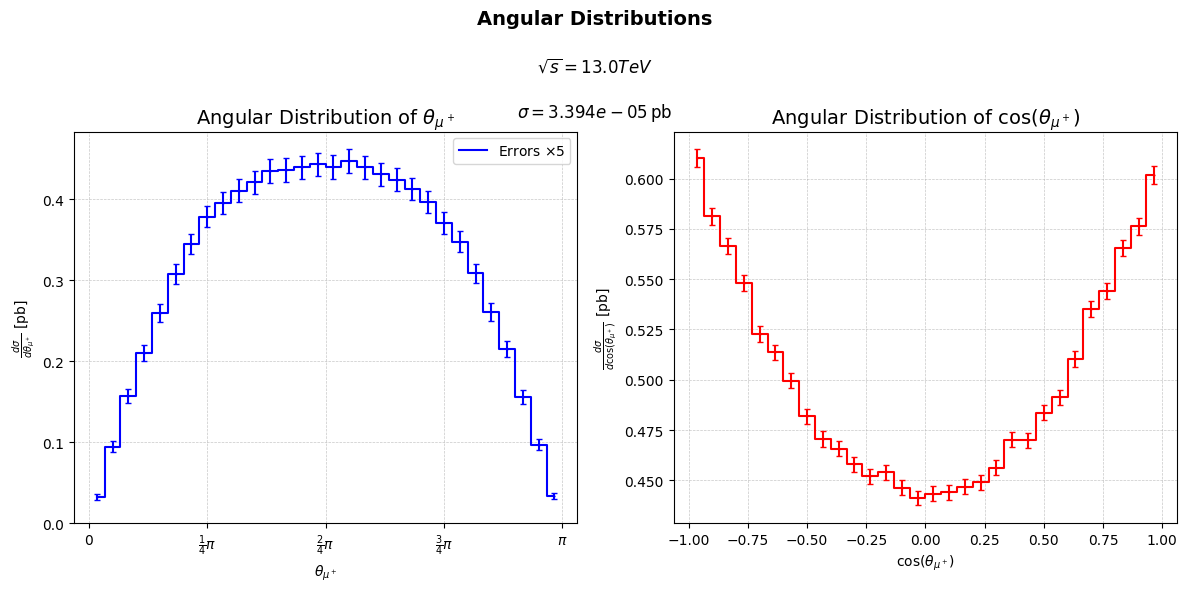

In [29]:
# Z boson decay products
plot_cos_distribution(muon_polar_angles, cross_section=CrossSection, com_energy=CentreOfMassEnergy, num_events=NumberOfEvents, decay_product="\\mu^+")
plot_cos_distribution(anti_muon_polar_angles, cross_section=CrossSection, com_energy=CentreOfMassEnergy, num_events=NumberOfEvents, decay_product="\\mu^-")

# W boson decay products
plot_cos_distribution(electron_neutrino_polar_angles, cross_section=CrossSection, com_energy=CentreOfMassEnergy, num_events=NumberOfEvents, decay_product="\\nu_e")
plot_cos_distribution(anti_electron_polar_angles, cross_section=CrossSection, com_energy=CentreOfMassEnergy, num_events=NumberOfEvents, decay_product="\\bar{e}")

# Anti-W boson decay products
plot_cos_distribution(electron_polar_angles, cross_section=CrossSection, com_energy=CentreOfMassEnergy, num_events=NumberOfEvents, decay_product="e^+")
plot_cos_distribution(anti_electron_neutrino_polar_angles, cross_section=CrossSection, com_energy=CentreOfMassEnergy, num_events=NumberOfEvents, decay_product="\\bar{\\nu}_e")

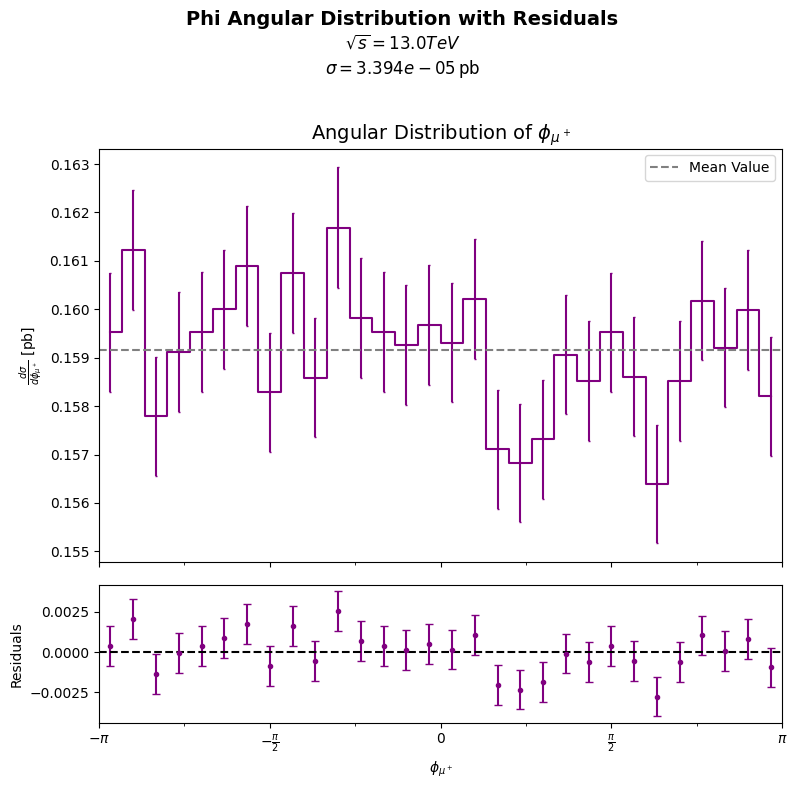

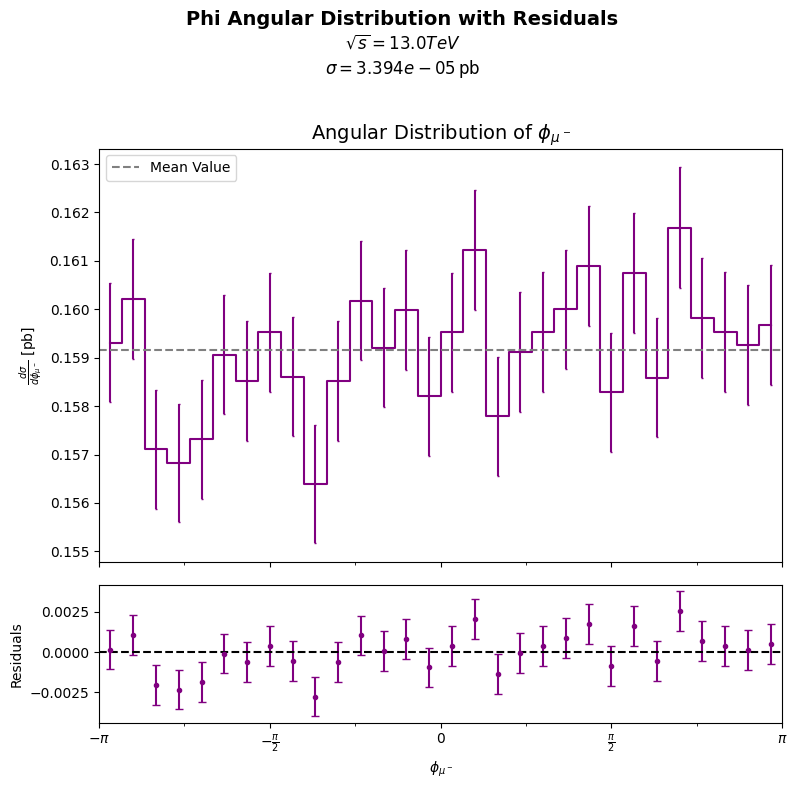

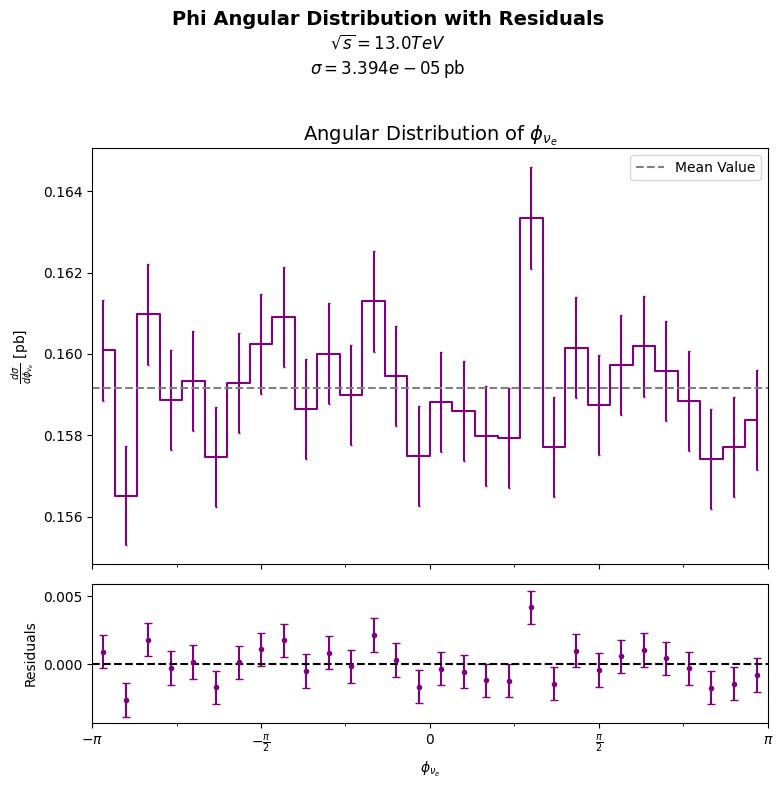

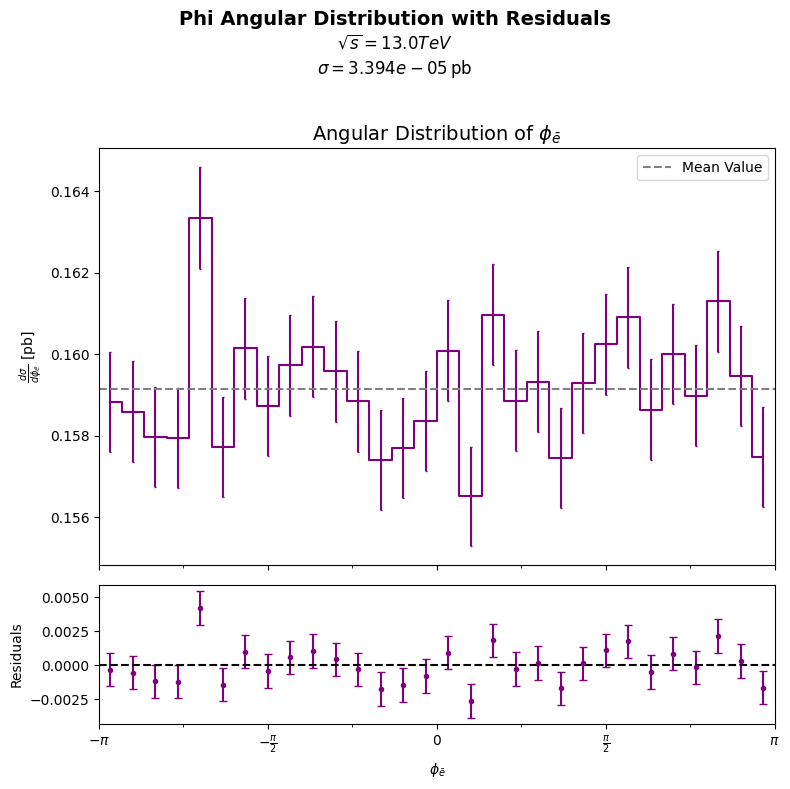

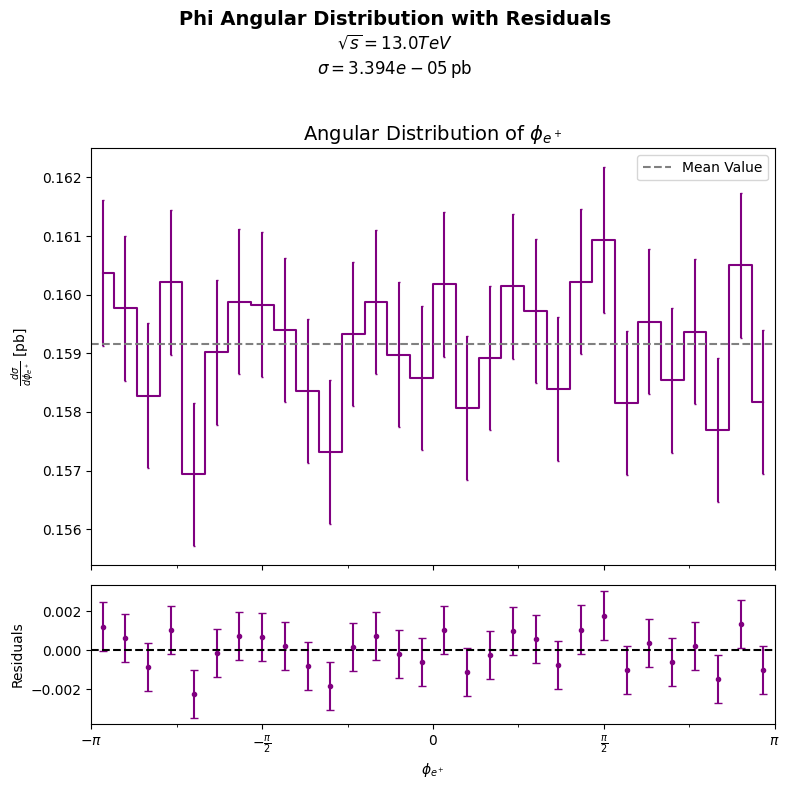

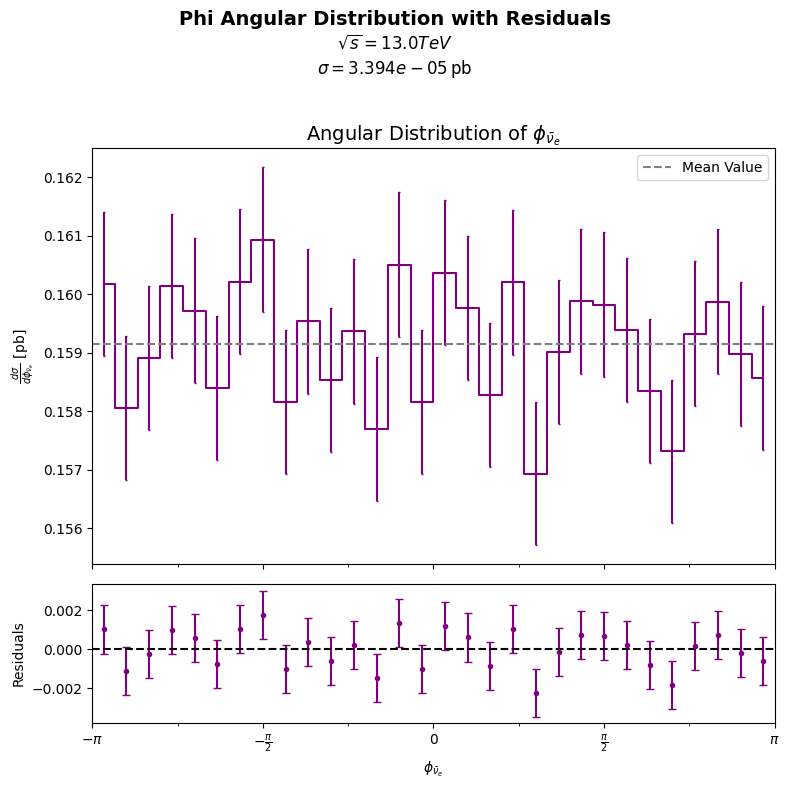

In [ ]:

# Z boson decay products
plot_phi_distribution(muon_azimuthal_angles, cross_section=CrossSection, com_energy=CentreOfMassEnergy, num_events=NumberOfEvents, decay_product="\\mu^+")
plot_phi_distribution(anti_muon_azimuthal_angles, cross_section=CrossSection, com_energy=CentreOfMassEnergy, num_events=NumberOfEvents, decay_product="\\mu^-")

# W boson decay products
plot_phi_distribution(electron_neutrino_azimuthal_angles, cross_section=CrossSection, com_energy=CentreOfMassEnergy, num_events=NumberOfEvents, decay_product="\\nu_e")
plot_phi_distribution(anti_electron_azimuthal_angles, cross_section=CrossSection, com_energy=CentreOfMassEnergy, num_events=NumberOfEvents, decay_product="\\bar{e}")

# Anti-W boson decay products
plot_phi_distribution(electron_azimuthal_angles, cross_section=CrossSection, com_energy=CentreOfMassEnergy, num_events=NumberOfEvents, decay_product="e^+")
plot_phi_distribution(anti_electron_neutrino_azimuthal_angles, cross_section=CrossSection, com_energy=CentreOfMassEnergy, num_events=NumberOfEvents, decay_product="\\bar{\\nu}_e")


### Helicity Fractions

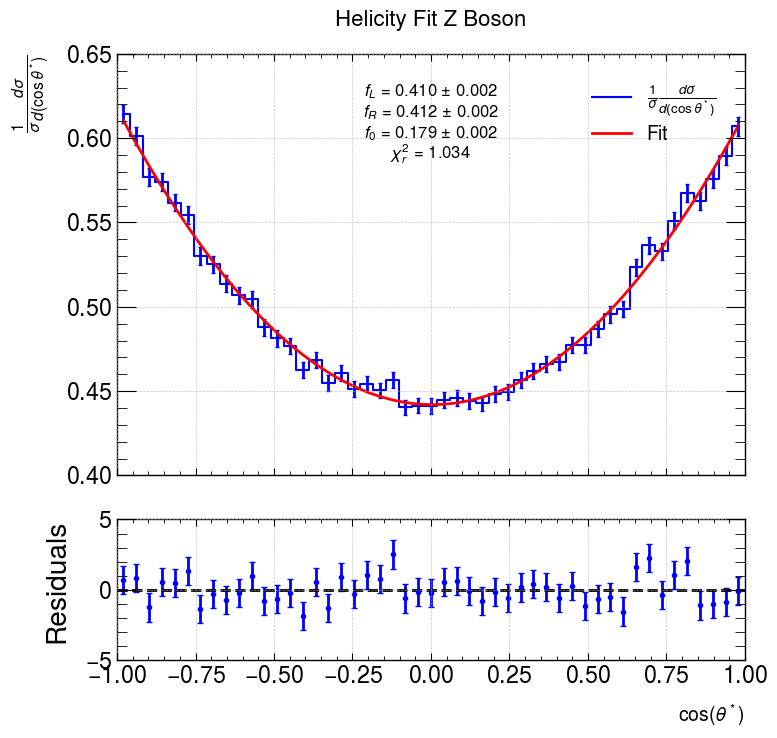

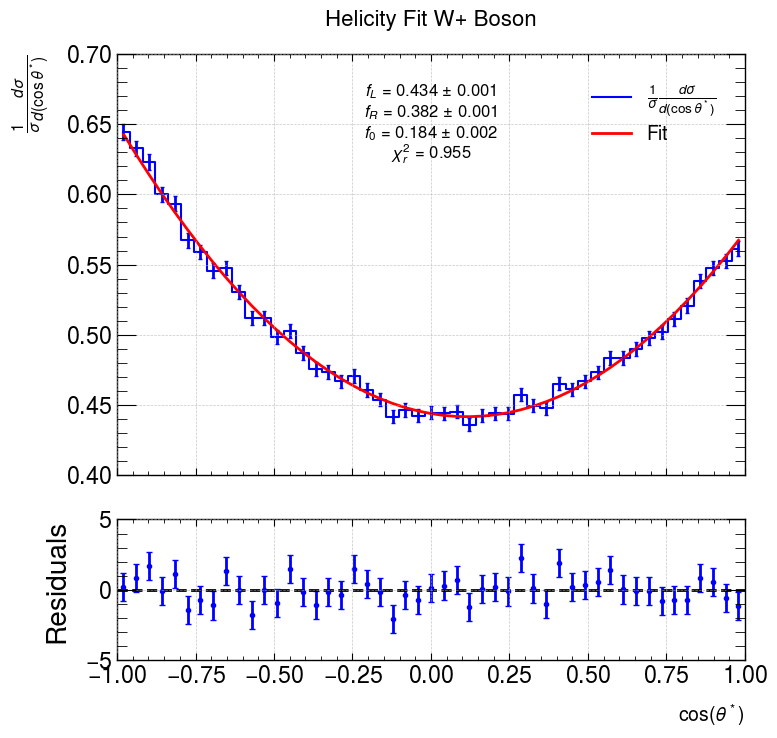

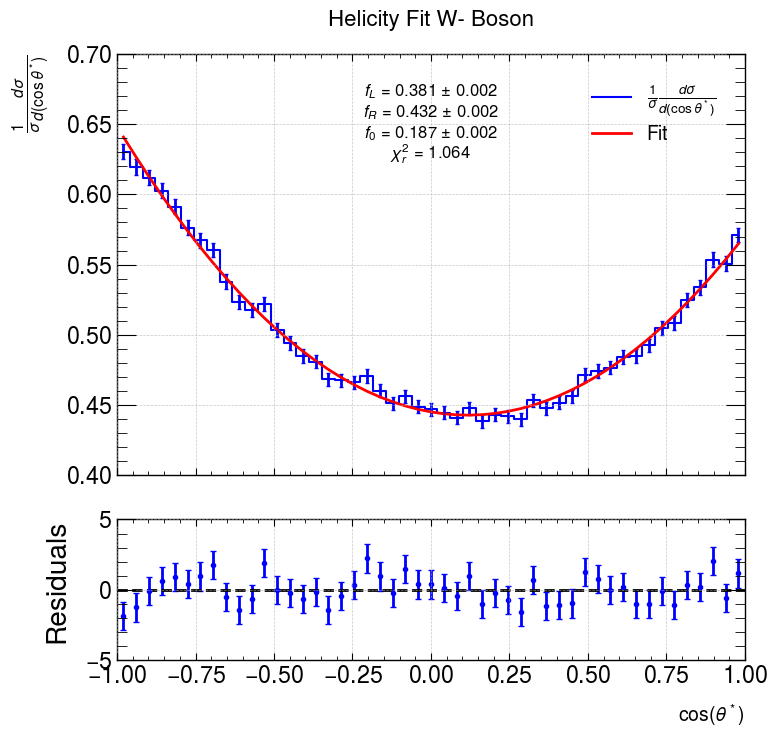

In [ ]:
helicity_parameter_z = calculate_helicity_fractions(muon_polar_angles, "Z", cross_section=CrossSection, num_events=NumberOfEvents, com_energy=CentreOfMassEnergy)
helicity_parameter_w = calculate_helicity_fractions(electron_polar_angles, "W+", cross_section=CrossSection, num_events=NumberOfEvents, com_energy=CentreOfMassEnergy)
helicity_parameter_anti_w = calculate_helicity_fractions(anti_electron_polar_angles, "W-", cross_section=CrossSection, num_events=NumberOfEvents, com_energy=CentreOfMassEnergy)


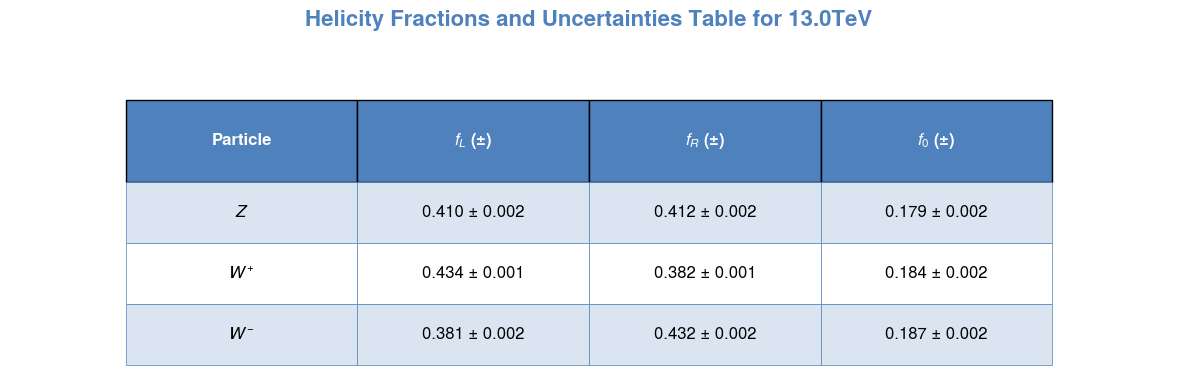

In [ ]:
plot_helicity_fractions_table([helicity_parameter_z, helicity_parameter_w, helicity_parameter_anti_w], ["$Z$", "$W^+$", "$W^-$"])


Helicity fractions as a function of partonic com energy

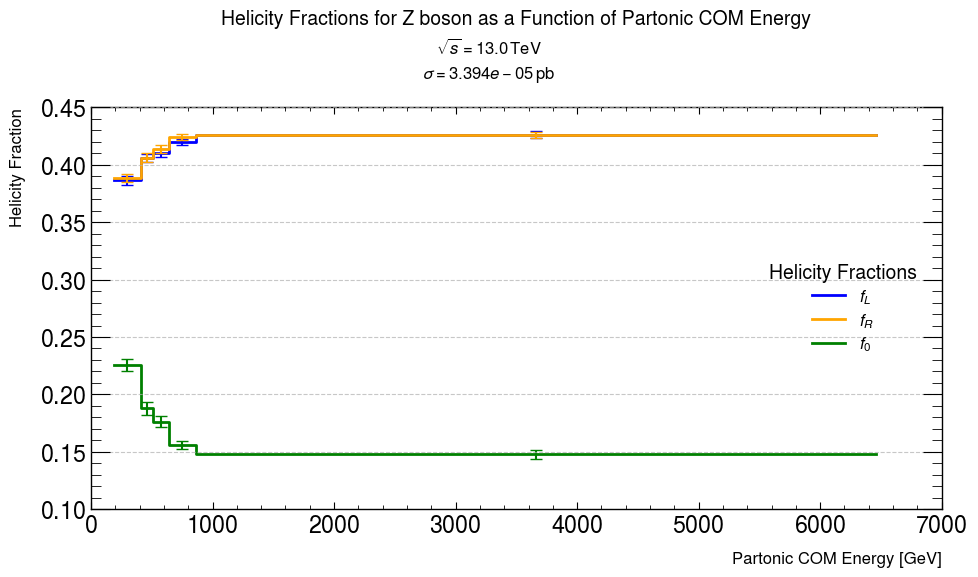

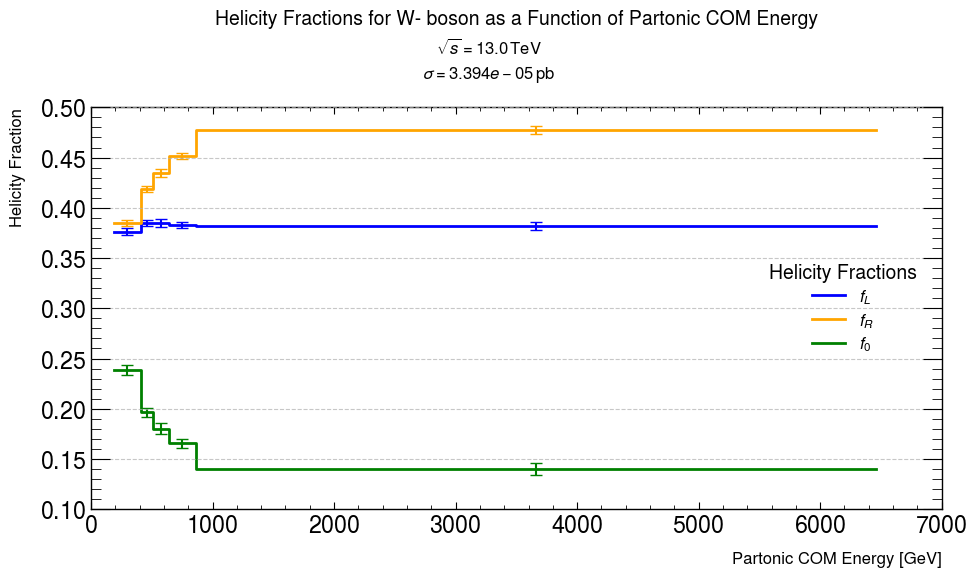

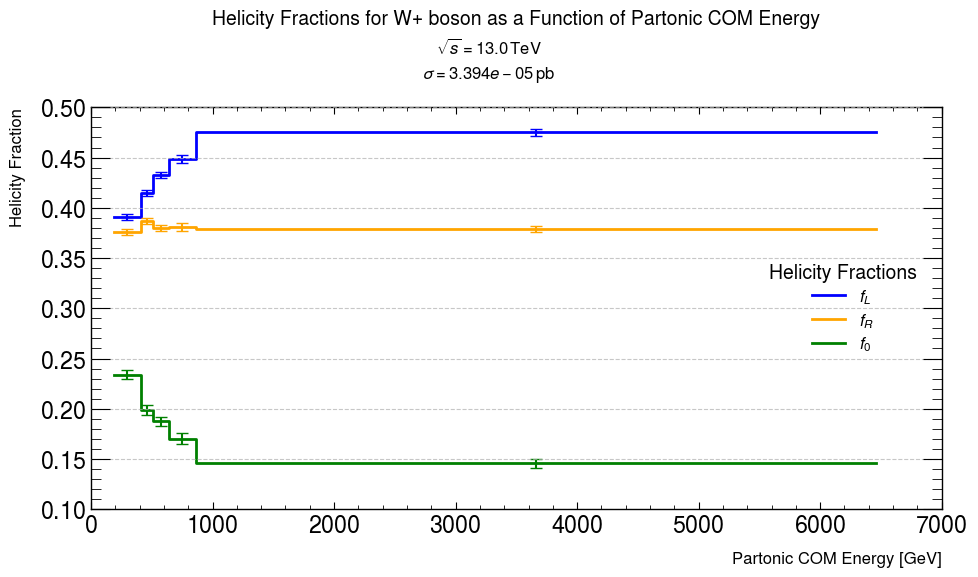

In [ ]:

charlies_badboy_funct(muon_rest, "Z", com_four_momentum, cross_section=CrossSection, beam_energy=CentreOfMassEnergy, num_events=NumberOfEvents, decay_product="mu+")
charlies_badboy_funct(electron_rest, "W-", com_four_momentum, cross_section=CrossSection, beam_energy=CentreOfMassEnergy, num_events=NumberOfEvents, decay_product="e-")
charlies_badboy_funct(anti_electron_rest, "W+", com_four_momentum, cross_section=CrossSection, beam_energy=CentreOfMassEnergy, num_events=NumberOfEvents, decay_product="e+")

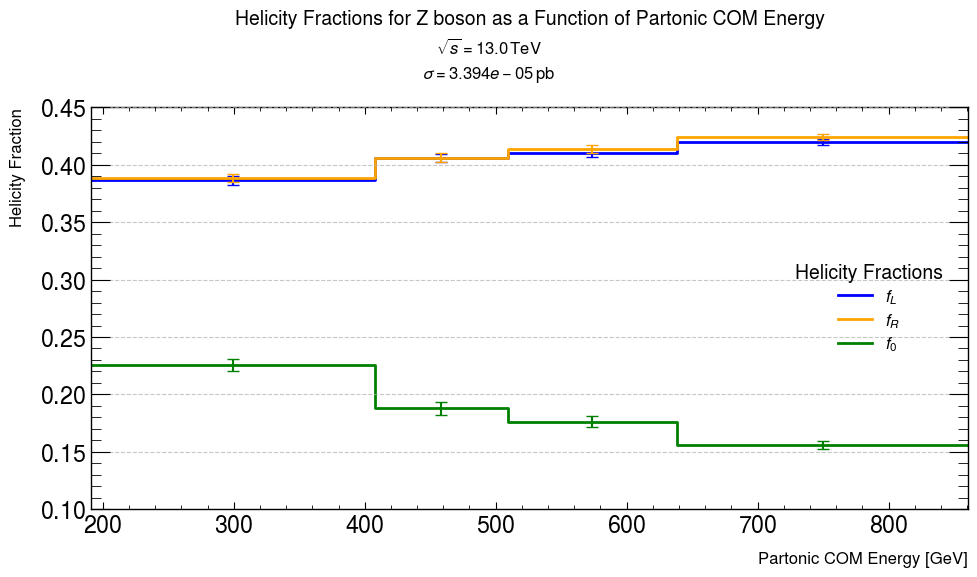

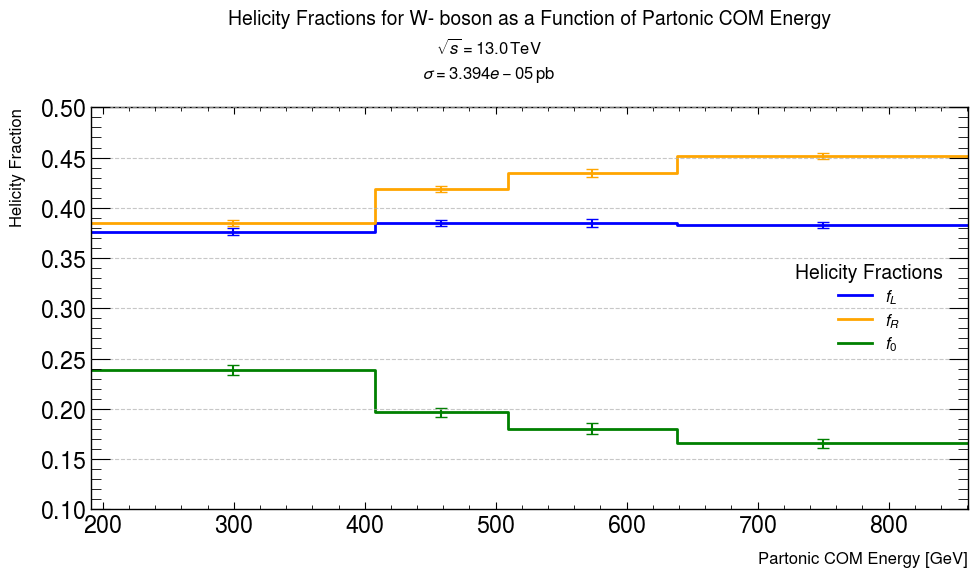

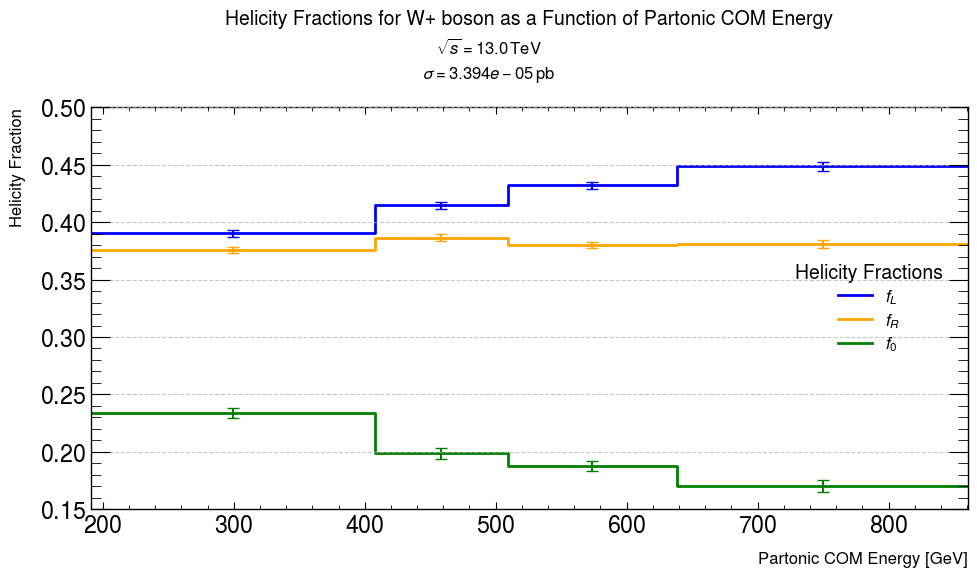

In [ ]:
charlies_badboy_funct_four_bins(muon_rest, "Z", com_four_momentum, cross_section=CrossSection, beam_energy=CentreOfMassEnergy, num_events=NumberOfEvents, decay_product="mu+")
charlies_badboy_funct_four_bins(electron_rest, "W-", com_four_momentum, cross_section=CrossSection, beam_energy=CentreOfMassEnergy, num_events=NumberOfEvents, decay_product="e-")
charlies_badboy_funct_four_bins(anti_electron_rest, "W+", com_four_momentum, cross_section=CrossSection, beam_energy=CentreOfMassEnergy, num_events=NumberOfEvents, decay_product="e+")